# Recurrent Neural Networks versus Ridge Regression for Extrapolation of Physics Data Sets

Julie Butler Hartley

October 14, 2020

Group Meeting


## Imports

Many, Many Imports

In [1]:
# To change directories
import sys

# For matrices and calculations
import numpy as np

# For machine learning (backend for keras)
import tensorflow as tf
# User-friendly machine learning library
# Front end for TensorFlow
import keras
# Different methods from Keras needed to create an RNN
# This is not necessary but it shortened function calls 
# that need to be used in the code.
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Activation 
from keras.layers.recurrent import SimpleRNN

# Another machine learning library--this one for ridge 
# regression
from sklearn.linear_model.ridge import Ridge

# For timing the code
from timeit import default_timer as timer

# For plotting
import matplotlib.pyplot as plt

# Data sets (mostly physics related)
from DataSets import *
from ElectronGas import *

Using TensorFlow backend.
/Library/Python/3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.linear_model.ridge module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)


## Test Data Set

Generated by applying couple cluster calculations to the pairing model.  The x data are the number of particle/hole states and the y data are the corresponding couple cluster doubles correlation energies.

**Note that at 20 data points this is a small data set by any standard, but especially by machine learning standards**

In [2]:
# Vary Dimension
datatype='VaryDimension'
X_tot = np.arange(2, 42, 2)
y_tot = np.array([-0.03077640549, -0.08336233266, -0.1446729567, -0.2116753732, -0.2830637392, -0.3581341341, -0.436462435, -0.5177783846,
	-0.6019067271, -0.6887363571, -0.7782028952, -0.8702784034, -0.9649652536, -1.062292565, -1.16231451, 
	-1.265109911, -1.370782966, -1.479465113, -1.591317992, -1.70653767])

## Recurrent Neural Network

Good article with animations: https://towardsdatascience.com/illustrated-guide-to-recurrent-neural-networks-79e5eb8049c9

### Formatting the Data

The way the recurrent neural networks are trained in this program differs from how machine learning algorithms are usually trained.  Typically a machine learning algorithm is trained by learning the relationship between the x data and the y data.  In this program, the recurrent neural network will be trained to recognize the relationship in a sequence of y values.  This is type of data formatting is typically used time series forcasting, but it can also be used in any extrapolation (time series forecasting is just a specific type of extrapolation along the time axis).  This method of data formatting does not use the x data and assumes that the y data are evenly spaced.

For a standard machine learning algorithm, the training data has the form of (x,y) so the machine learning algorithm learns to assiciate a y value with a given x value.  This is useful when the test data has x values within the same range as the training data.  However, for this application, the x values of the test data are outside of the x values of the training data and the traditional method of training a machine learning algorithm does not work as well.  For this reason, the recurrent neural network is trained on sequences of y values of the form ((y1, y2), y3), so that the network is concerned with learning the pattern of the y data and not the relation between the x and y data.  As long as the pattern of y data outside of the training region stays relatively stable compared to what was inside the training region, this method of training can produce accurate extrapolations to y values far removed from the training data set.

The idea behind formatting the data in this way comes from [this resource](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/) and [this one](https://fairyonice.github.io/Understand-Keras%27s-RNN-behind-the-scenes-with-a-sin-wave-example.html).

The following method takes in a y data set and formats it so the "x data" are of the form (y1, y2) and the "y data" are of the form y3, with extra brackets added in to make the resulting arrays compatable with both Keras and Tensorflow.

Note: Using a sequence length of two is not required for time series forecasting so any length of sequence could be used (for example instead of ((y1, y2) y3) you could change the length of sequence to be 4 and the resulting data points would have the form ((y1, y2, y3, y4), y5)).  While the following method can be used to create a data set of any sequence length, the remainder of the code expects the length of sequence to be 2.  This is because the data sets are very small and the higher the lenght of the sequence the less resulting data points.

In [3]:
# FORMAT_DATA
def format_data_rnn(data, length_of_sequence = 2):  
    """
        Inputs:
            data(a numpy array): the data that will be the inputs to the recurrent neural
                network
            length_of_sequence (an int): the number of elements in one iteration of the
                sequence patter.  For a function approximator use length_of_sequence = 2.
        Returns:
            rnn_input (a 3D numpy array): the input data for the recurrent neural network.  Its
                dimensions are length of data - length of sequence, length of sequence, 
                dimnsion of data
            rnn_output (a numpy array): the training data for the neural network
        Formats data to be used in a recurrent neural network.
    """

    X, Y = [], []
    for i in range(len(data)-length_of_sequence):
        # Get the next length_of_sequence elements
        a = data[i:i+length_of_sequence]
        # Get the element that immediately follows that
        b = data[i+length_of_sequence]
        # Reshape so that each data point is contained in its own array
        a = np.reshape (a, (len(a), 1))
        X.append(a)
        Y.append(b)
    rnn_input = np.array(X)
    rnn_output = np.array(Y)

    return rnn_input, rnn_output

### Visualize how the data is formatted

In [4]:
test = np.arange(1, 100)

# Testing a sequence length of 2
x, y = format_data_rnn(test, 2)

print (x[0], y[0])
print()
print (x[1],y[1])

print ('*********')

# Testing a sequence length of 10
x, y = format_data_rnn(test, 10)

print (x[0], y[0])
print()
print (x[1],y[1])

[[1]
 [2]] 3

[[2]
 [3]] 4
*********
[[ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]] 11

[[ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]] 12


### Define a Recurrent Neural Network in Keras

The following neural network contains an input layer, 5 hidden layers, and an output layer.  The hidden layers are 2 dense (feedforward layers) followed by 3 simple recurrent neural network layers.  The dense (feedforward) layers act as sort of a pre-processor for the data before it hits the recurrent layers.

In [5]:
def rnn(length_of_sequences, hidden_neurons, loss, optimizer, activation, rate, batch_size = None, stateful = False):
    """
        Inputs:
            length_of_sequences (an int): the length of sequence used to format the data set
            hidden_neurons (an int): the number of neurons to be used in the SimpleRNN layers, or double the number
                of neurons to be used in the Dense layers
            loss (a string): the loss function to be used
            optimizer (a string): the optimizer to be used
            activation (a string): the activation to be used in the dense layers
            rate (an int or float): the L2 regulization rate (not used in this example)
            batch_size (an int): Default value is None.  See Keras documentation of SimpleRNN.
            stateful (a boolean): Default value is False.  See Keras documentation of SimpleRNN.
        Returns:
            model (a Keras model): a compiled recurrent neural network consisting of one input layer followed by
                2 dense (feedforward layers), then three simple recurrent neural network layers, and finally an
                output layer.
        Builds and compiles a Keras recurrent neural network with specified parameters using two hidden dense 
        layers followed by three hidden simple recurrent neural network layers.
    """
    # Number of neurons in the input and output layers
    in_out_neurons = 1
    # Input layer
    inp = Input(batch_shape=(batch_size, 
                length_of_sequences, 
                in_out_neurons)) 
    # Hidden dense layers
    dnn = Dense(hidden_neurons/2, activation=activation, name='dnn')(inp)
    dnn1 = Dense(hidden_neurons/2, activation=activation, name='dnn1')(dnn)
    # Hidden simple recurrent layers
    rnn1 = SimpleRNN(hidden_neurons, 
                    return_sequences=True,
                    stateful = stateful,
                    name="RNN1", use_bias=True,recurrent_dropout=0.0, kernel_regularizer=keras.regularizers.l2(rate))(dnn1)
    rnn2 = SimpleRNN(hidden_neurons, 
                    return_sequences=True,
                    stateful = stateful,
                    name="RNN2", use_bias=True,recurrent_dropout=0.0, kernel_regularizer=keras.regularizers.l2(rate))(rnn1)
    rnn = SimpleRNN(hidden_neurons, 
                    return_sequences=False,
                    stateful = stateful,
                    name="RNN", use_bias=True,recurrent_dropout=0.0, kernel_regularizer=keras.regularizers.l2(rate))(rnn2)
    # Output layer
    dens = Dense(in_out_neurons,name="dense")(rnn)
    # Build the model
    model = Model(inputs=[inp],outputs=[dens])
    # Compile the model
    model.compile(loss=loss, optimizer=optimizer)  
    # Return the model
    return model

### Predicting New Points With A Trained Recurrent Neural Network

This is needed because each new predicted points gets formatted and used to predict the next point in the series.  Also includes a small data anlysis and graphing code.

In [6]:
def test_rnn (x1, y_test, plot_min, plot_max):
    """
        Inputs:
            x1 (a list or numpy array): The complete x component of the data set
            y_test (a list or numpy array): The complete y component of the data set
            plot_min (an int or float): the smallest x value used in the training data
            plot_max (an int or float): the largest x valye used in the training data
        Returns:
            None.
        Uses a trained recurrent neural network model to predict future points in the 
        series.  Computes the MSE of the predicted data set from the true data set, saves
        the predicted data set to a csv file, and plots the predicted and true data sets w
        while also displaying the data range used for training.
    """
    # Add the training data as the first dim points in the predicted data array as these
    # are known values.
    y_pred = y_test[:dim].tolist()
    # Generate the first input to the trained recurrent neural network using the last two 
    # points of the training data.  Based on how the network was trained this means that it
    # will predict the first point in the data set after the training data.  All of the 
    # brackets are necessary for Tensorflow.
    next_input = np.array([[[y_test[dim-2]], [y_test[dim-1]]]])
    # Save the very last point in the training data set.  This will be used later.
    last = [y_test[dim-1]]

    # Iterate until the complete data set is created.
    for i in range (dim, len(y_test)):
        # Predict the next point in the data set using the previous two points.
        next = model.predict(next_input)
        # Append just the number of the predicted data set
        y_pred.append(next[0][0])
        # Create the input that will be used to predict the next data point in the data set.
        next_input = np.array([[last, next[0]]], dtype=np.float64)
        last = next

    # Print the mean squared error between the known data set and the predicted data set.
    print('MSE: ', np.square(np.subtract(y_test, y_pred)).mean())
    # Save the predicted data set as a csv file for later use
    name = datatype + 'Predicted'+str(dim)+'.csv'
    np.savetxt(name, y_pred, delimiter=',')
    # Plot the known data set and the predicted data set.  The red box represents the region that was used
    # for the training data.
    fig, ax = plt.subplots()
    ax.plot(x1, y_test, label="true", linewidth=3)
    ax.plot(x1, y_pred, 'g-.',label="predicted", linewidth=4)
    ax.legend()
    # Created a red region to represent the points used in the training data.
    ax.axvspan(plot_min, plot_max, alpha=0.25, color='red')
    plt.show()

### Testing the performance of the recurrent neural network on the couple cluster data

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2, 1)]            0         
_________________________________________________________________
dnn (Dense)                  (None, 2, 250)            500       
_________________________________________________________________
dnn1 (Dense)                 (None, 2, 250)            62750     
_________________________________________________________________
RNN1 (SimpleRNN)             (None, 2, 500)            375500    
_________________________________________________________________
RNN2 (SimpleRNN)             (None, 2, 500)            500500    
_________________________________________________________________
RNN (SimpleRNN)              (None, 500)               500500    
_________________________________________________________________
dense (Dense)                (None, 1)                

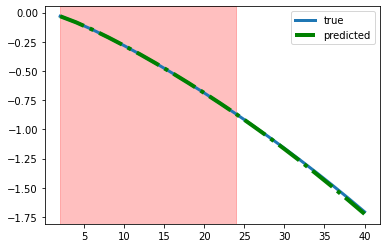

Time:  12.351180615999999


In [7]:
# Check to make sure the data set is complete
assert len(X_tot) == len(y_tot)

# This is the number of points that will be used in as the training data
dim=12

# Separate the training data from the whole data set
X_train = X_tot[:dim]
y_train = y_tot[:dim]


# Generate the training data for the RNN, using a sequence of 2
rnn_input, rnn_training = format_data_rnn(y_train, 2)


# Create a recurrent neural network in Keras and produce a summary of the 
# machine learning model
# Change the method name to reflect which network you want to use
# These parameters were determined through hyperparameter tuning with 
# has a huge time cost
model = rnn(2, 500, 'mse', 'adam', 'relu', 0.0)
model.summary()

# Start the timer.  Want to time training+testing
start = timer()
# Fit the model using the training data genenerated above using 150 training iterations and a 5%
# validation split.  Setting verbose to True prints information about each training iteration.
hist = model.fit(rnn_input, rnn_training, batch_size=None, epochs=350, 
                 verbose=False,validation_split=0.05)

# Use the trained neural network to predict more points of the data set
test_rnn(X_tot, y_tot, X_tot[0], X_tot[dim-1])
# Stop the timer and calculate the total time needed.
end = timer()
print('Time: ', end-start)

The total run time was about 15 seconds (it varies) for one data set run of 20 points and a relatively small network.  The time needed to train a recurrent neural network will increase drastically for more complicated data sets and networks.  In addition the hyperparameter tuning process can involve hundreds of different parameter combinations to find the optimal values for a data set.  Even at just 15 seconds per run that is still very time consuming.

## Ridge Regression


I have investigated linear regression, ridge regression, and kernel ridge regression algorithms and their abilities to extrapolate to unknown values of a data set.  For the sake of this presentation, let's just concentrate on ridge regression, but this code can be easily extended to linear regression or kernel ridge regression.

Using the loss function for the linear regression model, the loss function for the ridge regression model can be easily written by adding an extra, regularization term.

$$J(\textbf{w}) = \sum_{i=1}^n (y_i - \hat{y}_i)^2 + \alpha\sum_{i=1}^n w_i^2$$

where $\textbf{y}$ is the true data and $\hat{\textbf{y}}$  is the predicted data.  This equation differs from the linear regression loss function by the
inclusion of the regularization term at the end. This term introduces
a small amount of bias into the algorithm, leading to a large drop in
the variance (bias-variance trade-off), allowing the ridge regression
algorithm to generalize to new data points better than regular linear
regression.  The term $\alpha$ is a hyperparameter which controls how
much bias is introduced into the algorithm (a larger value of $\alpha$
means more bias is added in). This second term is a regularization
term and therefore $\alpha$ can also be referred to as the strength of
the regularization.

### Formatting the data

An unique aspect of my work is that I have carried over the time series forecasting formatting typically only used in recurrent neural networks and have applied it to regression algorithms.

This produces the same data format as the above method, but with less brackets to correspond to sklearn's requirements.

In [8]:
def format_data_regression(data, length_of_sequence = 2):
    """
        Inputs:
            data(a numpy array): the data that will be the inputs to the recurrent neural
                network
            length_of_sequence (an int): the number of elements in one iteration of the
                sequence patter.  For a function approximator use length_of_sequence = 2.
        Returns:
            rnn_input (a 2D numpy array): the input data for the regression.
            rnn_output (a numpy array): the training data for the regression
        Formats data in a time series-inspired way to be used in ridge and kernel ridge
        regression.
        NOTE: formally format_data_dnn from RNN codes.
    """
    # Lists to hold the formatted data
    inputs, outputs = [], []
    # Loop through the data
    for i in range(len(data)-length_of_sequence):
        # Get the next length_of_sequence elements
        a = data[i:i+length_of_sequence]
        # Get the element that immediately follows that
        b = data[i+length_of_sequence]
        # Add new points to the returned arrays
        inputs.append(a)
        outputs.append(b)
    # Format the lists as numpy arrays
    inputs = np.array(inputs)
    outputs = np.array(outputs)
    # Return the two formatted arrays
    return inputs, outputs

### Comparison of Data Formats

In [9]:
test = np.arange(1, 100)

# Testing a sequence length of 2 with RNN formatting
x, y = format_data_rnn(test, 2)

print (x[0], y[0])
print()
print (x[1],y[1])

print ('*********')

# Testing a sequence length of 2 with regression formatting
x, y = format_data_regression(test, 2)

print (x[0], y[0])
print()
print (x[1],y[1])

[[1]
 [2]] 3

[[2]
 [3]] 4
*********
[1 2] 3

[2 3] 4


### Define the Ridge Regression algorithm

This method defines the ridge regression alogorithm with set parameters, fits the algorithm to some training data, precits new points using the trained model, and then calculates the MSE between the predicted data and the known data.

In [10]:
    def ridge_regression (X_train, y_train, y_tot, training_dim, params, verbose=True, seq=2):
        """
            Inputs:
                X_train (a list or numpy array): the x component of the training data
                y_train (a list or numpy array): the y component of the training data
                y_tot (a list of numpy array): the total set of data points (training plus validation)
                training_dim (an int): the size of the traing data (i.e. the number of points
                    from y_tot that are used in the training)
                params (a list): contains the parameters of the ridge regression 
                    algorithm.  In order: normalize, alpha, and solver.
                verbose (a boolean): True case: prints the MSE score of the extrapolated data
                    when compared to the true data.
            Returns:
                y_return (a list): the known points and the extrapolated data points
                Unnamed (a float): the MSE error between the true data and the predicted
                    data
            Performs ridge regression on the given data set using the given parameters
            and then extrapolates data points to get a complete data set.  Prints the MSE 
            score of the extrapolated data set compared to the true data set if desired and
            then returns the extrapolated data set.
                    
        """
        # To ensure that all parameters are present 
        assert len(params)==3

        # Set up the model
        r = Ridge (normalize = params[0], alpha = params[1], solver = params[2])    

        # Fit the model to the training data
        r.fit(X_train, y_train)

        # Use the trained model to predict the points in the validation set
        y_return = y_tot[:training_dim].tolist()
        next_input = [[y_return[-2], y_return[-1]]]
        last = y_return[-1]
        while len(y_return) < len(y_tot):
            # Catch for overflow errors which can happen on predictions
            # with bad parameter combinations
            try:
                next = r.predict(next_input)
            except:
                print ('Overflow encountered on predicton')
                return None, 1e10
            y_return.append(next[0])
            next_input =[[last, next[0]]]
            last = next[0]

        # Print the MSE error if needed
        if verbose:  
            print ('RIDGE MSE VALUE: ', ((y_tot-y_return)**2).mean())

        # Return the predicted points and the MSE error
        return y_return, ((y_tot-y_return)**2).mean()

### Test the Ridge Regression Algorithm

RIDGE MSE VALUE:  2.1468721634814087e-06


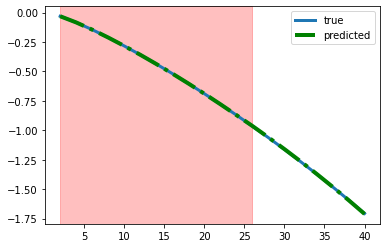

Time:  0.2289284579999986


In [11]:
# Check to make sure the data set is complete
assert len(X_tot) == len(y_tot)

# This is the number of points that will be used in as the training data
dim=12

# Separate the training data from the whole data set
X_train = X_tot[:dim]
y_train = y_tot[:dim]

# Optimal parameters determined through hyperparameter tuning
# Normalize, alpha, solver
params = [False, 0.015717837177731613, 'svd']

# Generate the training data for the RNN, using a sequence of 2
regression_input, regression_training = format_data_regression(y_train, 2)

start = timer()

y_pred, MSE = ridge_regression(regression_input, regression_training, y_tot, dim, params)

# Plot the known data set and the predicted data set.  The red box represents the region that was used
# for the training data.
fig, ax = plt.subplots()
ax.plot(X_tot, y_tot, label="true", linewidth=3)
ax.plot(X_tot, y_pred, 'g-.',label="predicted", linewidth=4)
ax.legend()
# Created a red region to represent the points used in the training data.
ax.axvspan(X_tot[0], X_tot[dim], alpha=0.25, color='red')
plt.show()
# Stop the timer and calculate the total time needed.
end = timer()
print('Time: ', end-start)

Not only does ridge regression produce a better fit than the recurrent neural network, it does so in significant less time.  This is especially beneficial when it comes to hyperparameter tuning.

## Electron Gas Data Set 

The current application of these algorithms are on an electron gas of inifinite size, attempting to use machine learning algorithms to extrapolate to the converged energy of the electron gas at the thermodynamic limit.  This work was inspired by this paper: https://arxiv.org/pdf/1605.05699.pdf

For all data sets the x data are the number of orbitals and the y data are the correlation energies.  The name convention is rs_[rs value for data set]\_N\_[number of particles]

An example of one data set:

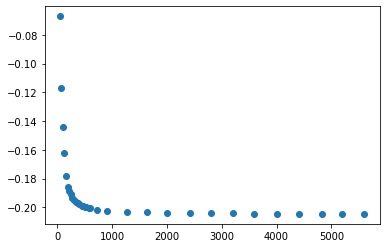

In [12]:
name, training_dim, X_tot, y_tot = rs_1_N_26()
plt.scatter(X_tot, y_tot)

At 33 total data points, this is the largest data set of the collection.  Unfortunately most of the data sets have 10 or fewer points which can make traning a machine learning model difficult especially since the data formatting reduces the total number of points

## Let's see how well we can predict the know data

RIDGE MSE VALUE:  2.1615890667535385e-07


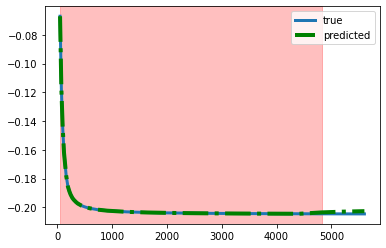

Time:  0.26117632100000066


In [13]:
# Check to make sure the data set is complete
assert len(X_tot) == len(y_tot)

# This is the number of points that will be used in as the training data
# Using a high training dimension to get the best fit in the 
# "converged" region
dim=30

# Separate the training data from the whole data set
X_train = X_tot[:dim]
y_train = y_tot[:dim]

params = [True, 3.88e-6, 'saga'] 

# Generate the training data for the RNN, using a sequence of 2
regression_input, regression_training = format_data_regression(y_train, 2)

start = timer()

y_pred, MSE = ridge_regression(regression_input, regression_training, y_tot, dim, params)

# Plot the known data set and the predicted data set.  The red box represents the region that was used
# for the training data.
fig, ax = plt.subplots()
ax.plot(X_tot, y_tot, label="true", linewidth=3)
ax.plot(X_tot, y_pred, 'g-.',label="predicted", linewidth=4)
ax.legend()
# Created a red region to represent the points used in the training data.
ax.axvspan(X_tot[0], X_tot[dim], alpha=0.25, color='red')
plt.show()
# Stop the timer and calculate the total time needed.
end = timer()
print('Time: ', end-start)

### Defining a ridge regression algorithm that can extrapolate to a converged value

The big difference here is that the algorithm extrapolates until the values are converged (at least to some threshold) and not to some set length of data set.

**Note that this algorithm uses autoregression**

In [14]:
    def ridge_regression_extrapolate (X_train, y_train, y_known, total_points, training_dim, params, isConvergence, convergence_threshold, verbose, seq=2):
        """
            Inputs:
                X_train (a list or numpy array): the x component of the training data
                y_train (a list or numpy array): the y component of the training data
                y_known (a list): the known data (aka the training data) in a 1D list
               total_points (an int): the total number of points needed in the final data set
                    including the number of training points
                training_dim (an int): the size of the traing data (i.e. the number of points
                    from y_tot that are used in the training)
                params (a list): contains the parameters of the ridge regression 
                    algorithm.  In order: normalize, alpha, and solver.
                verbose (a boolean): True case: prints the MSE score of the extrapolated data
                    when compared to the true data.
                seq (an int): the length of the series to use in the time series formatting (default 
                    value is 2)    
            Returns:
                y_return (a list): the known points and the extrapolated data points
            Performs ridge regression on the given data set using the given parameters
            and then extrapolates data points to get a complete data set. Ridge 
            regression is performed after each point is extrapolated to hopefully decrease 
            the average MSE score.  Prints the MSE score of the extrapolated data set 
            compared to the true data set if desired and then returns the extrapolated data
            set.
                    
        """
        # To ensure that all parameters are present
        assert len(params)==3

        # Set up the model
        r = Ridge (normalize = params[0], alpha = params[1], solver = params[2])

        # Add the known training data to the predicted points list
        y_return = y_known.tolist()
        second_last = y_return[-2]
        last = y_return[-1]

        X_train, y_train = format_data_regression(y_return)
        # Fit the model
        r.fit(X_train, y_train)

        # While the length of the predicted points list is less than the total number of 
        # needed points
        while np.abs(second_last - last) > convergence_threshold:
            # Ensure that there are enough points the the predicted points list to be 
            # properly formatted.  Re-fitting the model only occurs when there are enough 
            # data points for the data to be properly formatted
            if len(y_return) % seq == 0:
                # Format the data
                X_train, y_train = format_data_regression(y_return)
                # Fit the model
                r.fit(X_train, y_train)
            # Predict the next point in the data set and add it to the list
            next_input = [[y_return[-2], y_return[-1]]]    
            next = r.predict(next_input)
            second_last = last
            last = next[0]    
            y_return.append(next[0])

            
        return y_return               


### Extrapolate until converged

Extrapolated Value:  -0.2022717815518657


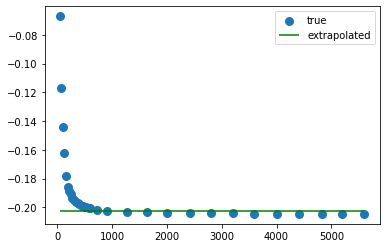

Time:  0.25381391500000205


In [15]:
# Check to make sure the data set is complete
assert len(X_tot) == len(y_tot)

# This is the number of points that will be used in as the training data
dim=len(X_tot)

# Separate the training data from the whole data set
X_train = X_tot[:dim]
y_train = y_tot[:dim]

# Same parameters as previous test
params = [True, 3.88e-6, 'saga']

# The data set only has five decimal places
convergence_threshold = 1e-8

# Generate the training data for the RNN, using a sequence of 2
regression_input, regression_training = format_data_regression(y_train, 2)

start = timer()

y_pred  = ridge_regression_extrapolate(regression_input, regression_training, y_tot, 100, dim, params, True, convergence_threshold, True)
print ('Extrapolated Value: ', y_pred[-1])

# Plot the known data set and the predicted data set.  The red box represents the region that was used
# for the training data.
plt.scatter(X_tot, y_tot, label="true", linewidth=3)
plt.hlines (y_pred[-1], X_tot[0], X_tot[-1], 'g', label='extrapolated')
plt.legend()
plt.show()
# Stop the timer and calculate the total time needed.
end = timer()
print('Time: ', end-start)

### Let's take a look at another data set from the same group

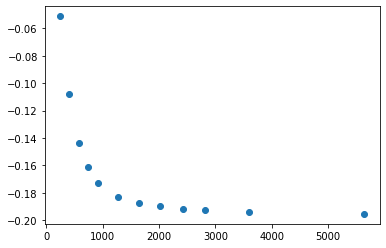

In [16]:
name, training_dim, X_tot, y_tot = rs_1_N_138()
plt.scatter(X_tot, y_tot)

Extrapolated Value:  -0.19452105654307952


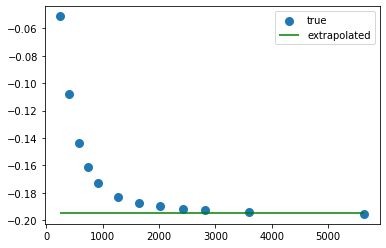

Time:  0.21388657500000008


In [17]:
assert len(X_tot) == len(y_tot)

# This is the number of points that will be used in as the training data
dim=len(X_tot)

# Separate the training data from the whole data set
X_train = X_tot[:dim]
y_train = y_tot[:dim]

# Determined through hyperparameter tuning
params = [True, 1.117111E-26, 'sag']

# The data set only has five decimal places
convergence_threshold = 1e-8

# Generate the training data for the RNN, using a sequence of 2
regression_input, regression_training = format_data_regression(y_train, 2)

start = timer()

y_pred  = ridge_regression_extrapolate(regression_input, regression_training, y_tot, 100, dim, params, True, convergence_threshold, True)
print ('Extrapolated Value: ', y_pred[-1])

# Plot the known data set and the predicted data set.  The red box represents the region that was used
# for the training data.
plt.scatter(X_tot, y_tot, label="true", linewidth=3)
plt.hlines (y_pred[-1], X_tot[0], X_tot[-1], 'g', label='extrapolated')
plt.legend()
plt.show()
# Stop the timer and calculate the total time needed.
end = timer()
print('Time: ', end-start)

### Extrapolation to the thermodynamic limit

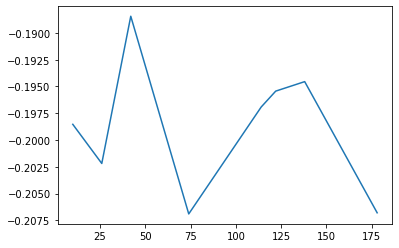

In [18]:
X_tot = np.array([10, 26, 42, 74, 114, 122, 138, 178])
y_tot = np.array([-0.1985319074, -0.20218377779084976, -0.188448089, -0.2068900836, -0.1969145017, -0.1954344112, -0.1945482018, -0.206784843])
plt.plot(X_tot, y_tot)

Not a very regular pattern, but let's see if it can be converged to within an acceptable tolerance.

Extrapolated Value:  -0.19803158657208886
Average Value:  -0.1987169769363562


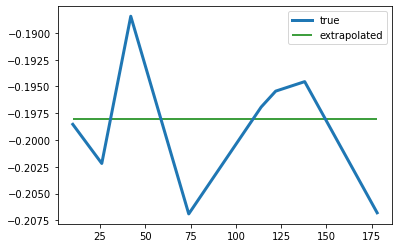

Time:  0.1787518100000014


In [19]:
# Check to make sure the data set is complete
assert len(X_tot) == len(y_tot)

# This is the number of points that will be used in as the training data
dim=len(X_tot)

# Separate the training data from the whole data set
X_train = X_tot[:dim]
y_train = y_tot[:dim]

params = [False, 0.0005, 'saga']

convergence_threshold = 1e-5

# Generate the training data for the RNN, using a sequence of 2
regression_input, regression_training = format_data_regression(y_train, 2)

start = timer()

y_pred  = ridge_regression_extrapolate(regression_input, regression_training, y_tot, 100, dim, params, True, convergence_threshold, True)
print ('Extrapolated Value: ', y_pred[-1])
print('Average Value: ', y_tot.mean())

# Plot the known data set and the predicted data set.  The red box represents the region that was used
# for the training data.
plt.plot(X_tot, y_tot, label="true", linewidth=3)
plt.hlines (y_pred[-1], X_tot[0], X_tot[-1], 'g', label='extrapolated')
plt.legend()
plt.show()
# Stop the timer and calculate the total time needed.
end = timer()
print('Time: ', end-start)

This exactly matches the literature value found using traditional methods of extrapolation.  It should be possible with some improvements to get a better result though, as this value is still a bit higher and what is considered the "true" value calcualted by GFMC.

## Improvements

* Complete the data set.  This method assumes that the y data are evenly spaced and as it stands the data set I have is incomplete and has gaps.  In addtion, lengthening the data set will definitely improve results.
* Apply recurrent neural networks to electron gas data set.  They do take longer because they are more complex, but complexity may be needed for this problem.
* Interpolate the missing data points using regression algorithms and standard data formatting.